In [1]:
from rf_classifier.models import CNNClassifier
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data.dataloader import DataLoader
from rf_classifier.transforms import RandomAffine, ColorRescale
from torch.optim import AdamW, SGD
import torch
import imageio as iio
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
  dev = "cuda:2"
else:
  dev = "cpu"
device = torch.device(dev)
print("Using", device)

Using cuda:2


In [3]:
valid_transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize((32,32), antialias=False), ColorRescale(-1,1)])
data = ImageFolder("../data/example_rfs", transform=valid_transforms)
id_to_class = {data.class_to_idx[class_name]: class_name for class_name in data.class_to_idx}

In [9]:
classifier = CNNClassifier(n_classes=len(data.classes))
classifier.load_state_dict(torch.load("../weights/cnn_classifier/first_simple_classifier.pth"))
classifier.to(device)
classifier.eval()

CNNClassifier(
  (resize): Resize(size=(32, 32), interpolation=bilinear, max_size=None, antialias=True)
  (convs): Sequential(
    (0): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
    (1): GELU(approximate='none')
    (2): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1))
    (3): GELU(approximate='none')
    (4): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1))
    (5): GELU(approximate='none')
    (6): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1))
    (7): GELU(approximate='none')
    (8): Conv2d(8, 8, kernel_size=(5, 5), stride=(1, 1))
    (9): GELU(approximate='none')
    (10): Flatten(start_dim=1, end_dim=-1)
  )
  (fcs): Sequential(
    (0): Linear(in_features=1152, out_features=256, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): GELU(approximate='none')
    (4): Linear(in_features=256, out_features=8, bias=True)
  )
)

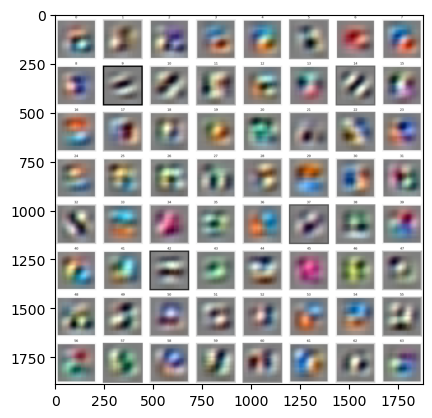

In [10]:
test = iio.v3.imread("/gpfs01/berens/user/fseel/projects/receptive-fields/imgs/spd_level/l1-4_3.png")
plt.imshow(test)
plt.show()

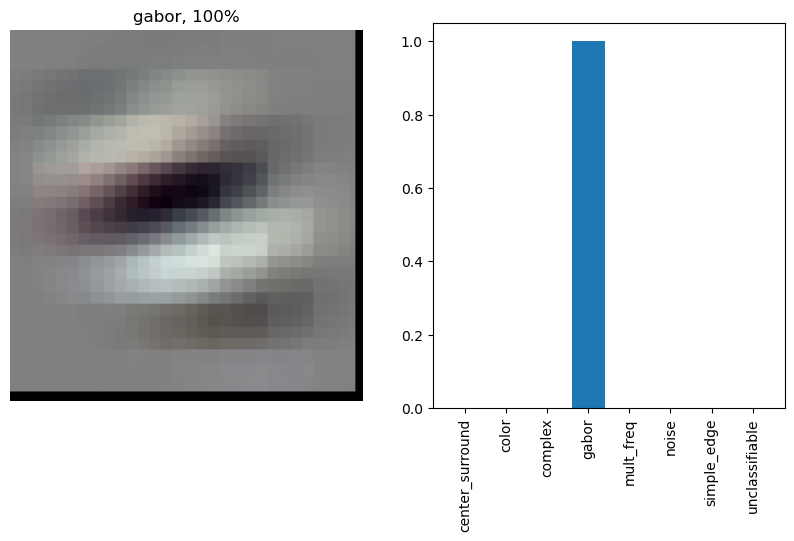

In [12]:
img_offset = 240
img_no = 9
test_img = test[30+img_no//8*img_offset:225+img_no//8*img_offset,20+(img_no%8)*img_offset:205+(img_no%8)*img_offset]
fig,axes = plt.subplots(1,2, figsize=(10,5))
axes[0].imshow(test_img)
result = classifier(valid_transforms(test_img)[None].to(device))
result_id = result.argmax().item()
axes[0].set_title(id_to_class[result_id] + ", {:.0%}".format(result[0,result_id]))
axes[0].set_axis_off()
axes[1].bar(data.classes,result[0].detach().cpu())
plt.xticks(rotation=90)
plt.show()